In [ ]:
print("Installing required packages...")
import subprocess
import sys

packages = [
    'sentence-transformers',
    'scikit-learn',
    'pandas',
    'numpy',
    'matplotlib',
    'seaborn',
    'requests'
]

for package in packages:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', package])

import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import json
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

from sentence_transformers import SentenceTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

print("✓ All packages installed successfully!\n")

In [ ]:
class CVEDataFetcher:
    def __init__(self):
        self.base_url = "https://services.nvd.nist.gov/rest/json/cves/2.0"

    def fetch_recent_cves(self, days=30, max_results=100):
        print(f"Fetching CVEs from last {days} days...")

        end_date = datetime.now()
        start_date = end_date - timedelta(days=days)

        params = {
            'pubStartDate': start_date.strftime('%Y-%m-%dT00:00:00.000'),
            'pubEndDate': end_date.strftime('%Y-%m-%dT23:59:59.999'),
            'resultsPerPage': min(max_results, 2000)
        }

        try:
            response = requests.get(self.base_url, params=params, timeout=30)
            response.raise_for_status()
            data = response.json()

            cves = []
            for item in data.get('vulnerabilities', [])[:max_results]:
                cve = item.get('cve', {})
                cve_id = cve.get('id', 'Unknown')

                descriptions = cve.get('descriptions', [])
                description = next((d['value'] for d in descriptions if d['lang'] == 'en'), 'No description')

                metrics = cve.get('metrics', {})
                cvss_v3 = metrics.get('cvssMetricV31', [{}])[0].get('cvssData', {})
                cvss_v2 = metrics.get('cvssMetricV2', [{}])[0].get('cvssData', {})

                base_score = cvss_v3.get('baseScore') or cvss_v2.get('baseScore') or 0.0
                severity = cvss_v3.get('baseSeverity') or 'UNKNOWN'

                published = cve.get('published', '')
                references = cve.get('references', [])

                cves.append({
                    'cve_id': cve_id,
                    'description': description,
                    'cvss_score': float(base_score),
                    'severity': severity,
                    'published': published,
                    'reference_count': len(references),
                    'attack_vector': cvss_v3.get('attackVector', 'UNKNOWN'),
                    'attack_complexity': cvss_v3.get('attackComplexity', 'UNKNOWN'),
                    'privileges_required': cvss_v3.get('privilegesRequired', 'UNKNOWN'),
                    'user_interaction': cvss_v3.get('userInteraction', 'UNKNOWN')
                })

            print(f"✓ Fetched {len(cves)} CVEs\n")
            return pd.DataFrame(cves)

        except Exception as e:
            print(f"Error fetching CVEs: {e}")
            return self._generate_sample_data(max_results)

    def _generate_sample_data(self, n=50):
        print("Using sample CVE data for demonstration...\n")

        sample_descriptions = [
            "A buffer overflow vulnerability in the network driver allows remote code execution",
            "SQL injection vulnerability in web application login form enables unauthorized access",
            "Cross-site scripting (XSS) vulnerability in user input validation",
            "Authentication bypass in admin panel due to weak session management",
            "Remote code execution via deserialization of untrusted data",
            "Path traversal vulnerability allows reading arbitrary files",
            "Privilege escalation through improper input validation",
            "Denial of service through resource exhaustion in API endpoint",
            "Information disclosure via error messages exposing sensitive data",
            "Memory corruption vulnerability in image processing library",
            "Command injection in file upload functionality",
            "Integer overflow leading to heap buffer overflow",
            "Use-after-free vulnerability in memory management",
            "Race condition in multi-threaded application",
            "Cryptographic weakness in password storage mechanism"
        ]

        severities = ['LOW', 'MEDIUM', 'HIGH', 'CRITICAL']
        attack_vectors = ['NETWORK', 'ADJACENT', 'LOCAL', 'PHYSICAL']
        complexities = ['LOW', 'HIGH']

        data = []
        for i in range(n):
            severity = np.random.choice(severities, p=[0.1, 0.3, 0.4, 0.2])
            score_ranges = {'LOW': (0.1, 3.9), 'MEDIUM': (4.0, 6.9), 'HIGH': (7.0, 8.9), 'CRITICAL': (9.0, 10.0)}

            data.append({
                'cve_id': f'CVE-2024-{10000+i}',
                'description': np.random.choice(sample_descriptions),
                'cvss_score': np.random.uniform(*score_ranges[severity]),
                'severity': severity,
                'published': (datetime.now() - timedelta(days=np.random.randint(1, 30))).isoformat(),
                'reference_count': np.random.randint(1, 10),
                'attack_vector': np.random.choice(attack_vectors),
                'attack_complexity': np.random.choice(complexities),
                'privileges_required': np.random.choice(['NONE', 'LOW', 'HIGH']),
                'user_interaction': np.random.choice(['NONE', 'REQUIRED'])
            })

        return pd.DataFrame(data)

In [ ]:
class VulnerabilityFeatureExtractor:
    def __init__(self):
        print("Loading sentence transformer model...")
        self.model = SentenceTransformer('all-MiniLM-L6-v2')
        print("✓ Model loaded\n")

        self.critical_keywords = {
            'execution': ['remote code execution', 'rce', 'execute', 'arbitrary code'],
            'injection': ['sql injection', 'command injection', 'code injection'],
            'authentication': ['bypass', 'authentication', 'authorization'],
            'overflow': ['buffer overflow', 'heap overflow', 'stack overflow'],
            'exposure': ['information disclosure', 'data leak', 'exposure'],
        }

    def extract_semantic_features(self, descriptions):
        print("Generating semantic embeddings...")
        embeddings = self.model.encode(descriptions, show_progress_bar=True)
        return embeddings

    def extract_keyword_features(self, df):
        print("Extracting keyword features...")

        for category, keywords in self.critical_keywords.items():
            df[f'has_{category}'] = df['description'].apply(
                lambda x: any(kw in x.lower() for kw in keywords)
            ).astype(int)

        df['desc_length'] = df['description'].apply(len)
        df['word_count'] = df['description'].apply(lambda x: len(x.split()))

        return df

    def encode_categorical_features(self, df):
        print("Encoding categorical features...")

        categorical_cols = ['attack_vector', 'attack_complexity', 'privileges_required', 'user_interaction']

        for col in categorical_cols:
            dummies = pd.get_dummies(df[col], prefix=col)
            df = pd.concat([df, dummies], axis=1)

        return df

In [ ]:
class VulnerabilityPrioritizer:
    def __init__(self):
        self.severity_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
        self.score_predictor = GradientBoostingRegressor(n_estimators=100, random_state=42)
        self.scaler = StandardScaler()
        self.feature_cols = None

    def prepare_features(self, df, embeddings):
        numeric_features = ['reference_count', 'desc_length', 'word_count']
        keyword_features = [col for col in df.columns if col.startswith('has_')]
        categorical_features = [col for col in df.columns if any(col.startswith(prefix) for prefix in ['attack_vector_', 'attack_complexity_', 'privileges_required_', 'user_interaction_'])]
        self.feature_cols = numeric_features + keyword_features + categorical_features
        X_structured = df[self.feature_cols].values
        X_embeddings = embeddings
        X_combined = np.hstack([X_structured, X_embeddings])
        return X_combined

    def train_models(self, X, y_severity, y_score):
        print("\nTraining ML models...")
        X_scaled = self.scaler.fit_transform(X)
        X_train, X_test, y_sev_train, y_sev_test, y_score_train, y_score_test = train_test_split(
            X_scaled, y_severity, y_score, test_size=0.2, random_state=42
        )
        self.severity_classifier.fit(X_train, y_sev_train)
        sev_pred = self.severity_classifier.predict(X_test)
        self.score_predictor.fit(X_train, y_score_train)
        score_pred = self.score_predictor.predict(X_test)
        print("\n--- Severity Classification Report ---")
        print(classification_report(y_sev_test, sev_pred))
        print(f"\n--- CVSS Score Prediction ---")
        print(f"RMSE: {np.sqrt(mean_squared_error(y_score_test, score_pred)):.2f}")
        return X_scaled

    def predict_priority(self, X):
        X_scaled = self.scaler.transform(X)
        severity_pred = self.severity_classifier.predict_proba(X_scaled)
        score_pred = self.score_predictor.predict(X_scaled)
        severity_weight = severity_pred[:, -1] * 0.4
        score_weight = (score_pred / 10.0) * 0.6
        priority_score = severity_weight + score_weight
        return priority_score, severity_pred, score_pred

    def get_feature_importance(self):
        importance = self.score_predictor.feature_importances_
        n_structured = len(self.feature_cols)
        structured_importance = importance[:n_structured]
        embedding_importance = importance[n_structured:]
        feature_imp_df = pd.DataFrame({
            'feature': self.feature_cols,
            'importance': structured_importance
        }).sort_values('importance', ascending=False)
        return feature_imp_df, embedding_importance.mean()

In [ ]:
class VulnerabilityAnalyzer:
    def __init__(self, n_clusters=5):
        self.n_clusters = n_clusters
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=42)

    def cluster_vulnerabilities(self, embeddings):
        print(f"\nClustering vulnerabilities into {self.n_clusters} groups...")
        clusters = self.kmeans.fit_predict(embeddings)
        return clusters

    def analyze_clusters(self, df, clusters):
        df['cluster'] = clusters
        print("\n--- Cluster Analysis ---")
        for i in range(self.n_clusters):
            cluster_df = df[df['cluster'] == i]
            print(f"\nCluster {i} ({len(cluster_df)} vulnerabilities):")
            print(f"  Avg CVSS Score: {cluster_df['cvss_score'].mean():.2f}")
            print(f"  Severity Distribution: {cluster_df['severity'].value_counts().to_dict()}")
            print(f"  Top keywords: ", end="")
            all_words = ' '.join(cluster_df['description'].values).lower()
            words = re.findall(r'\b[a-z]{4,}\b', all_words)
            common = Counter(words).most_common(5)
            print(', '.join([w for w, _ in common]))
        return df

Installing required packages...
✓ All packages installed successfully!

AI-ASSISTED VULNERABILITY SCANNER WITH ML PRIORITIZATION

Fetching CVEs from last 30 days...
✓ Fetched 50 CVEs

Dataset Overview:
  Total CVEs: 50
  Date Range: 2025-11-29 to 2025-12-01
  Severity Breakdown: {'MEDIUM': 29, 'HIGH': 12, 'CRITICAL': 5, 'LOW': 3, 'UNKNOWN': 1}

Loading sentence transformer model...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✓ Model loaded

Generating semantic embeddings...


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Extracting keyword features...
Encoding categorical features...

Training ML models...

--- Severity Classification Report ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.60      1.00      0.75         6
           2       0.00      0.00      0.00         2

    accuracy                           0.60        10
   macro avg       0.20      0.33      0.25        10
weighted avg       0.36      0.60      0.45        10


--- CVSS Score Prediction ---
RMSE: 1.98

Clustering vulnerabilities into 5 groups...

--- Cluster Analysis ---

Cluster 0 (9 vulnerabilities):
  Avg CVSS Score: 5.79
  Severity Distribution: {'MEDIUM': 4, 'HIGH': 4, 'UNKNOWN': 1}
  Top keywords: this, version, user, access, issue

Cluster 1 (5 vulnerabilities):
  Avg CVSS Score: 7.64
  Severity Distribution: {'HIGH': 3, 'CRITICAL': 1, 'MEDIUM': 1}
  Top keywords: this, version, vulnerability, been, catcher

Cluster 2 (4 vulnerabilities

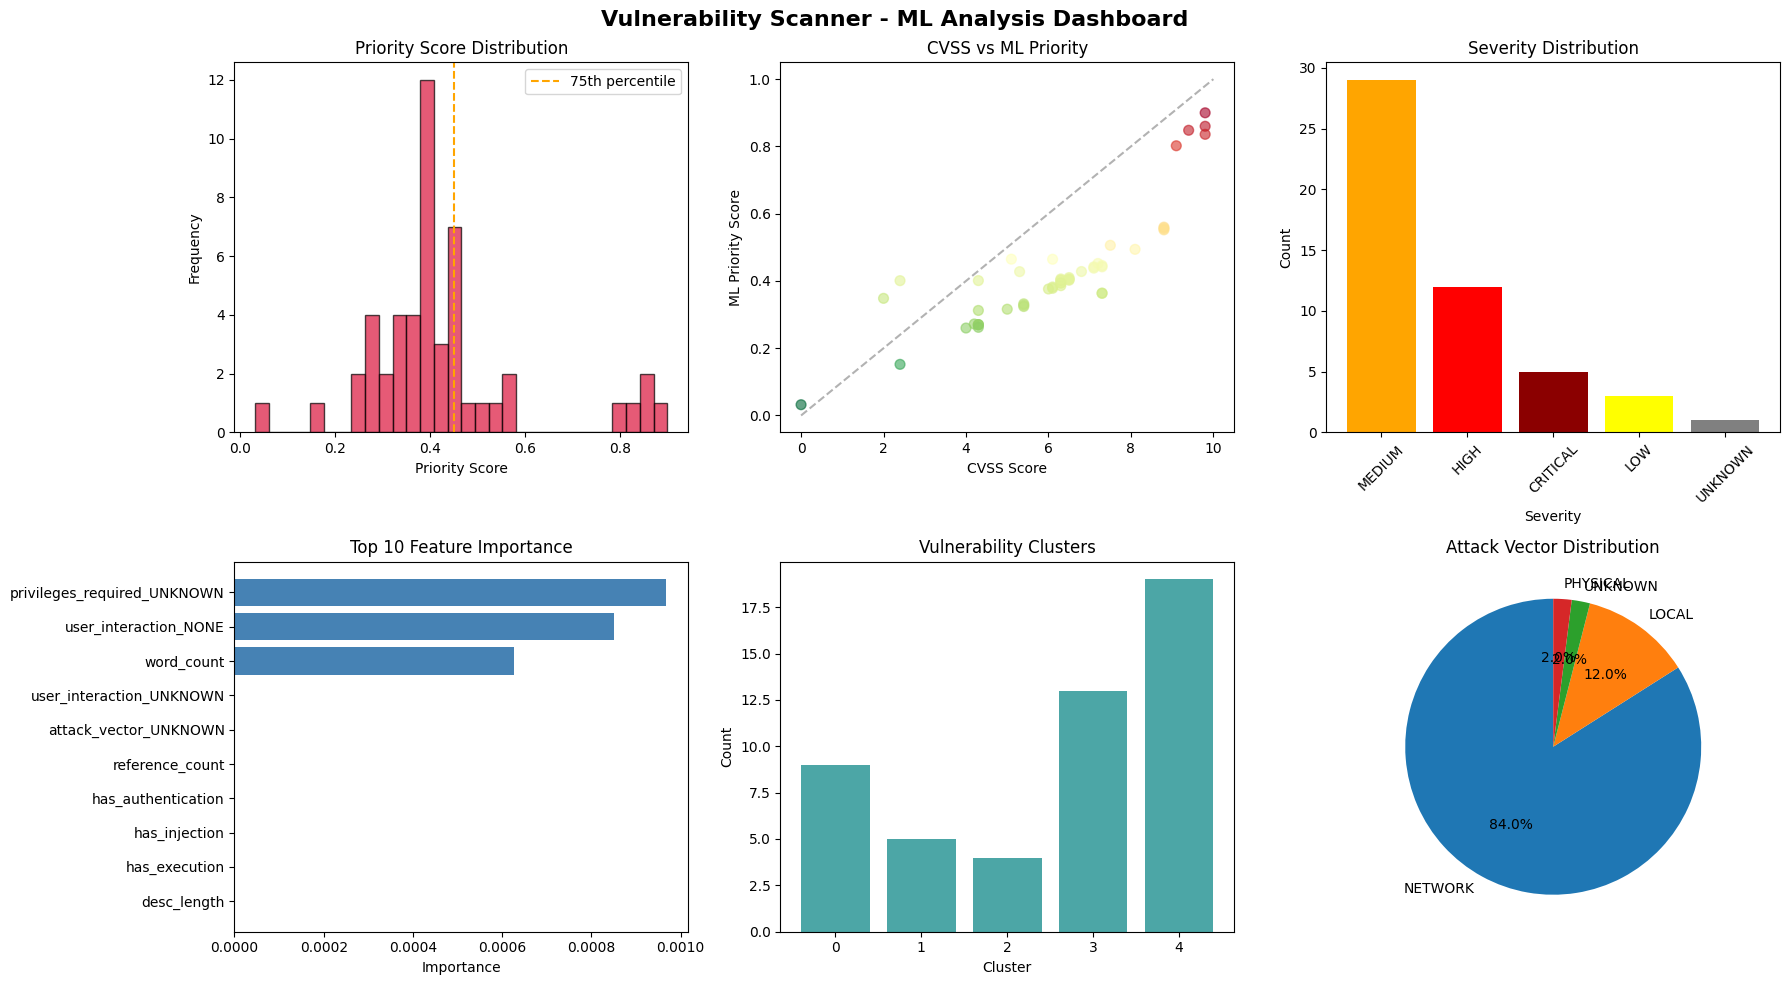


ANALYSIS COMPLETE

Results summary:
  High Priority (>0.7): 5 vulnerabilities
  Medium Priority (0.4-0.7): 23
  Low Priority (<0.4): 22

✓ All analyses completed successfully!

You can now:
  - Access results via 'results_df' DataFrame
  - Use 'prioritizer' to predict new vulnerabilities
  - Explore 'analyzer' for clustering insights


In [3]:
def visualize_results(df, priority_scores, feature_importance):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Vulnerability Scanner - ML Analysis Dashboard', fontsize=16, fontweight='bold')
    axes[0, 0].hist(priority_scores, bins=30, color='crimson', alpha=0.7, edgecolor='black')
    axes[0, 0].set_xlabel('Priority Score')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Priority Score Distribution')
    axes[0, 0].axvline(np.percentile(priority_scores, 75), color='orange', linestyle='--', label='75th percentile')
    axes[0, 0].legend()
    axes[0, 1].scatter(df['cvss_score'], priority_scores, alpha=0.6, c=priority_scores, cmap='RdYlGn_r', s=50)
    axes[0, 1].set_xlabel('CVSS Score')
    axes[0, 1].set_ylabel('ML Priority Score')
    axes[0, 1].set_title('CVSS vs ML Priority')
    axes[0, 1].plot([0, 10], [0, 1], 'k--', alpha=0.3)
    severity_counts = df['severity'].value_counts()
    colors = {'CRITICAL': 'darkred', 'HIGH': 'red', 'MEDIUM': 'orange', 'LOW': 'yellow'}
    axes[0, 2].bar(severity_counts.index, severity_counts.values, color=[colors.get(s, 'gray') for s in severity_counts.index])
    axes[0, 2].set_xlabel('Severity')
    axes[0, 2].set_ylabel('Count')
    axes[0, 2].set_title('Severity Distribution')
    axes[0, 2].tick_params(axis='x', rotation=45)
    top_features = feature_importance.head(10)
    axes[1, 0].barh(top_features['feature'], top_features['importance'], color='steelblue')
    axes[1, 0].set_xlabel('Importance')
    axes[1, 0].set_title('Top 10 Feature Importance')
    axes[1, 0].invert_yaxis()
    if 'cluster' in df.columns:
        cluster_counts = df['cluster'].value_counts().sort_index()
        axes[1, 1].bar(cluster_counts.index, cluster_counts.values, color='teal', alpha=0.7)
        axes[1, 1].set_xlabel('Cluster')
        axes[1, 1].set_ylabel('Count')
        axes[1, 1].set_title('Vulnerability Clusters')
    attack_vector_counts = df['attack_vector'].value_counts()
    axes[1, 2].pie(attack_vector_counts.values, labels=attack_vector_counts.index, autopct='%1.1f%%', startangle=90)
    axes[1, 2].set_title('Attack Vector Distribution')
    plt.tight_layout()
    plt.show()

def main():
    print("="*70)
    print("AI-ASSISTED VULNERABILITY SCANNER WITH ML PRIORITIZATION")
    print("="*70)
    print()
    fetcher = CVEDataFetcher()
    df = fetcher.fetch_recent_cves(days=30, max_results=50)
    print(f"Dataset Overview:")
    print(f"  Total CVEs: {len(df)}")
    print(f"  Date Range: {df['published'].min()[:10]} to {df['published'].max()[:10]}")
    print(f"  Severity Breakdown: {df['severity'].value_counts().to_dict()}")
    print()
    feature_extractor = VulnerabilityFeatureExtractor()
    embeddings = feature_extractor.extract_semantic_features(df['description'].tolist())
    df = feature_extractor.extract_keyword_features(df)
    df = feature_extractor.encode_categorical_features(df)
    prioritizer = VulnerabilityPrioritizer()
    X = prioritizer.prepare_features(df, embeddings)
    severity_map = {'LOW': 0, 'MEDIUM': 1, 'HIGH': 2, 'CRITICAL': 3, 'UNKNOWN': 1}
    y_severity = df['severity'].map(severity_map).values
    y_score = df['cvss_score'].values
    X_scaled = prioritizer.train_models(X, y_severity, y_score)
    priority_scores, severity_probs, score_preds = prioritizer.predict_priority(X)
    df['ml_priority_score'] = priority_scores
    df['predicted_score'] = score_preds
    analyzer = VulnerabilityAnalyzer(n_clusters=5)
    clusters = analyzer.cluster_vulnerabilities(embeddings)
    df = analyzer.analyze_clusters(df, clusters)
    feature_imp, emb_imp = prioritizer.get_feature_importance()
    print(f"\n--- Feature Importance ---")
    print(feature_imp.head(10))
    print(f"\nAverage embedding importance: {emb_imp:.4f}")
    print("\n" + "="*70)
    print("TOP 10 PRIORITY VULNERABILITIES")
    print("="*70)
    top_vulns = df.nlargest(10, 'ml_priority_score')[['cve_id', 'cvss_score', 'ml_priority_score', 'severity', 'description']]
    for idx, row in top_vulns.iterrows():
        print(f"\n{row['cve_id']} [Priority: {row['ml_priority_score']:.3f}]")
        print(f"  CVSS: {row['cvss_score']:.1f} | Severity: {row['severity']}")
        print(f"  {row['description'][:100]}...")
    print("\n\nGenerating visualizations...")
    visualize_results(df, priority_scores, feature_imp)
    print("\n" + "="*70)
    print("ANALYSIS COMPLETE")
    print("="*70)
    print(f"\nResults summary:")
    print(f"  High Priority (>0.7): {(priority_scores > 0.7).sum()} vulnerabilities")
    print(f"  Medium Priority (0.4-0.7): {((priority_scores >= 0.4) & (priority_scores <= 0.7)).sum()}")
    print(f"  Low Priority (<0.4): {(priority_scores < 0.4).sum()}")
    return df, prioritizer, analyzer

if __name__ == "__main__":
    results_df, prioritizer, analyzer = main()
    print("\n✓ All analyses completed successfully!")
    print("\nYou can now:")
    print("  - Access results via 'results_df' DataFrame")
    print("  - Use 'prioritizer' to predict new vulnerabilities")
    print("  - Explore 'analyzer' for clustering insights")